In [1]:
from fl_puf.FederatedDataset.PartitionTypes.representative import Representative
from fl_puf.FederatedDataset.PartitionTypes.balanced_and_unbalanced import BalancedAndUnbalanced
from fl_puf.FederatedDataset.PartitionTypes.unbalanced_partition import UnbalancedPartition
import torch
from fl_puf.FederatedDataset.Utils.utils import PartitionUtils
from DPL.Utils.dataset_utils import DatasetUtils
from fl_puf.Utils.utils import Utils
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

/home/lcorbucci/fl_privacy_utility_fairness/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-13 11:48:35,738	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [45]:
celeba_df = pd.read_csv("./data/celeba/original_merged.csv")
celeba_df.shape

(202599, 43)

In [46]:
labels = celeba_df["Smiling"].values
gender = celeba_df["Male"].values
combinations = [(label, gen) for label, gen in zip(labels, gender)]
combinations_with_index = [
    (label, gen, index) for index, (label, gen) in enumerate(zip(labels, gender))
]
counter_combinations = Counter(combinations)
counter_combinations

Counter({(1, -1): 63871, (-1, 1): 50636, (-1, -1): 54294, (1, 1): 33798})

In [47]:
# to_remove = 33798 / 2
# to_be_removed = []
# for label, gen, index in combinations_with_index:
#     if label == 1 and gen == 1 and len(to_be_removed) < to_remove:
#         to_be_removed.append(index)

# celeba_df = celeba_df.drop(to_be_removed)
# celeba_df.shape
# labels = celeba_df["Smiling"].values
# gender = celeba_df["Male"].values
# combinations = [(label, gen) for label, gen in zip(labels, gender)]
# combinations_with_index = [
#     (label, gen, index) for index, (label, gen) in enumerate(zip(labels, gender))
# ]
# counter_combinations = Counter(combinations)
# counter_combinations

In [48]:
# celeba_df.to_csv("./data/celeba/new_test_reduced.csv", index=False)

In [2]:
train_set, test_set = DatasetUtils.download_dataset(
    "celeba",
    train_csv="original_merged",
    debug=True,
    base_path="./data/celeba",
)

In [3]:
train_path = Utils.prepare_dataset_for_FL(
    dataset=train_set,
    dataset_name="celeba",
    base_path="./data",
)

Generating unified dataset
Data Correctly downloaded


In [4]:
images, sensitive_attribute, labels = torch.load(train_path)
mapping = {-1: 0, 1: 1}
sensitive_attribute = torch.tensor([mapping[item] for item in sensitive_attribute])

idx = torch.tensor(list(range(len(images))))
dataset = [idx, sensitive_attribute, labels]
pool_size = 150
group_to_reduce = (1, 1)
group_to_increment = (0, 1)

Mean of disparity 0.35565897470181396 - std 0.1436563356371556


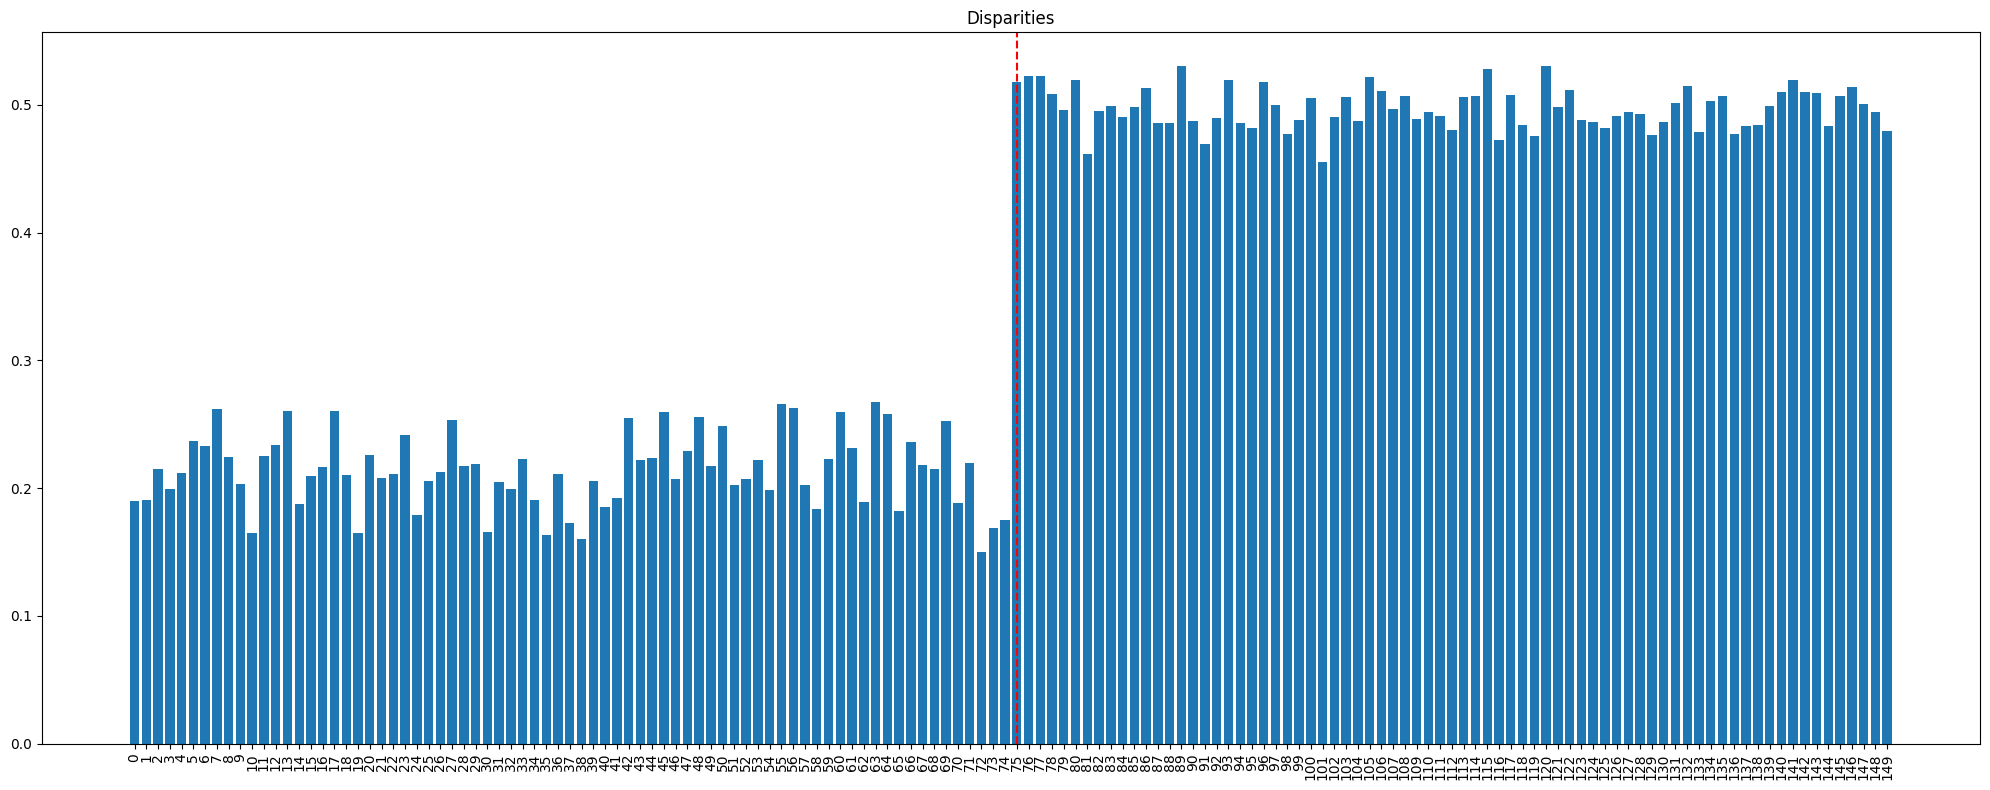

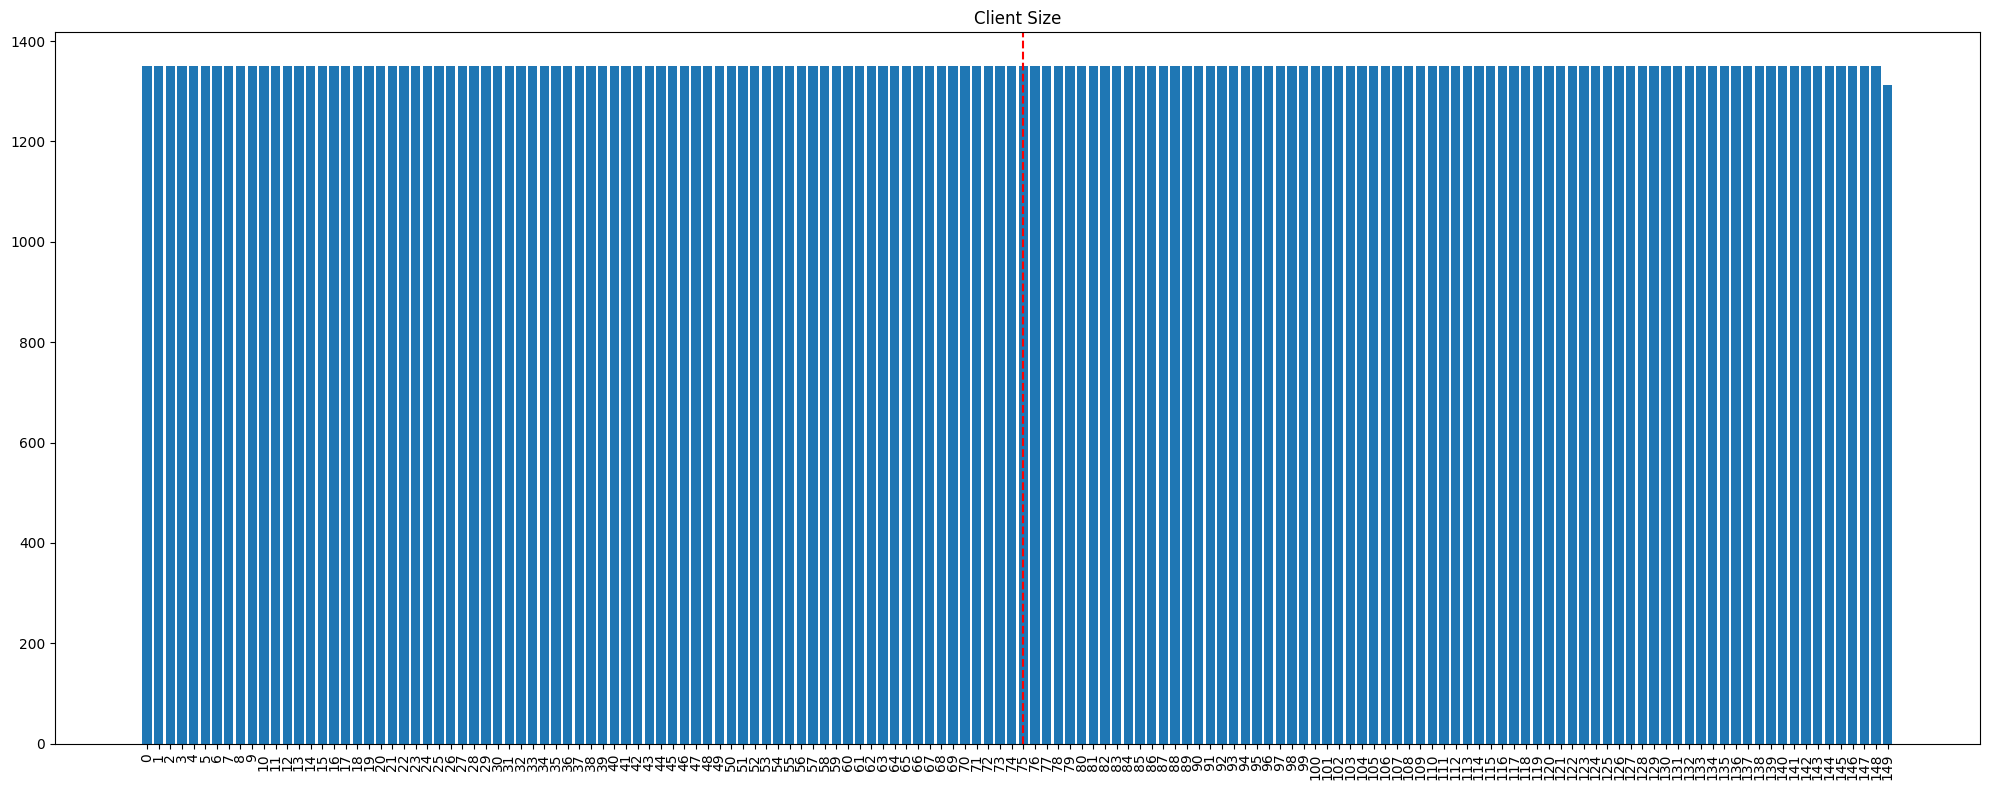

In [5]:
number_of_samples_per_node = 1350
ratio_unfair_nodes = 0.50
ratio_unfairness = (0.9, 0.9)

partitions_index_list, metadata = Representative.do_partitioning(
    labels=labels,
    sensitive_features=sensitive_attribute,
    num_partitions=pool_size,
    total_num_classes=2,
    group_to_reduce=group_to_reduce,
    group_to_increment=group_to_increment,
    number_of_samples_per_node=number_of_samples_per_node,
    ratio_unfair_nodes=ratio_unfair_nodes,
    ratio_unfairness=ratio_unfairness,
)
partitions = PartitionUtils.create_splitted_dataset_from_tuple(
    splitted_indexes=partitions_index_list,
    dataset=dataset,
)

# ratio = 0.3
# ratio_list = [ratio, 1 - ratio]
# partitions_index_list = UnbalancedPartition.do_partitioning(
#     labels=labels,
#     sensitive_features=sensitive_attribute,
#     num_partitions=pool_size,
#     total_num_classes=2,
#     alpha=5,
#     ratio_list=ratio_list,
# )
# partitions = PartitionUtils.create_splitted_dataset_from_tuple(
#     splitted_indexes=partitions_index_list,
#     dataset=dataset,
# )

In [6]:
clients_target_sensitive = []
combinations = []
for partition in partitions:
    targets = partition[2]
    sensitive = partition[1]
    clients_target_sensitive.append([(target.item(), sv.item()) for target, sv in zip(targets, sensitive)])

Counter({(1, 0): 442, (1, 1): 429, (0, 0): 340, (0, 1): 139})
Counter({(0, 1): 485, (1, 0): 420, (0, 0): 386, (1, 1): 21})


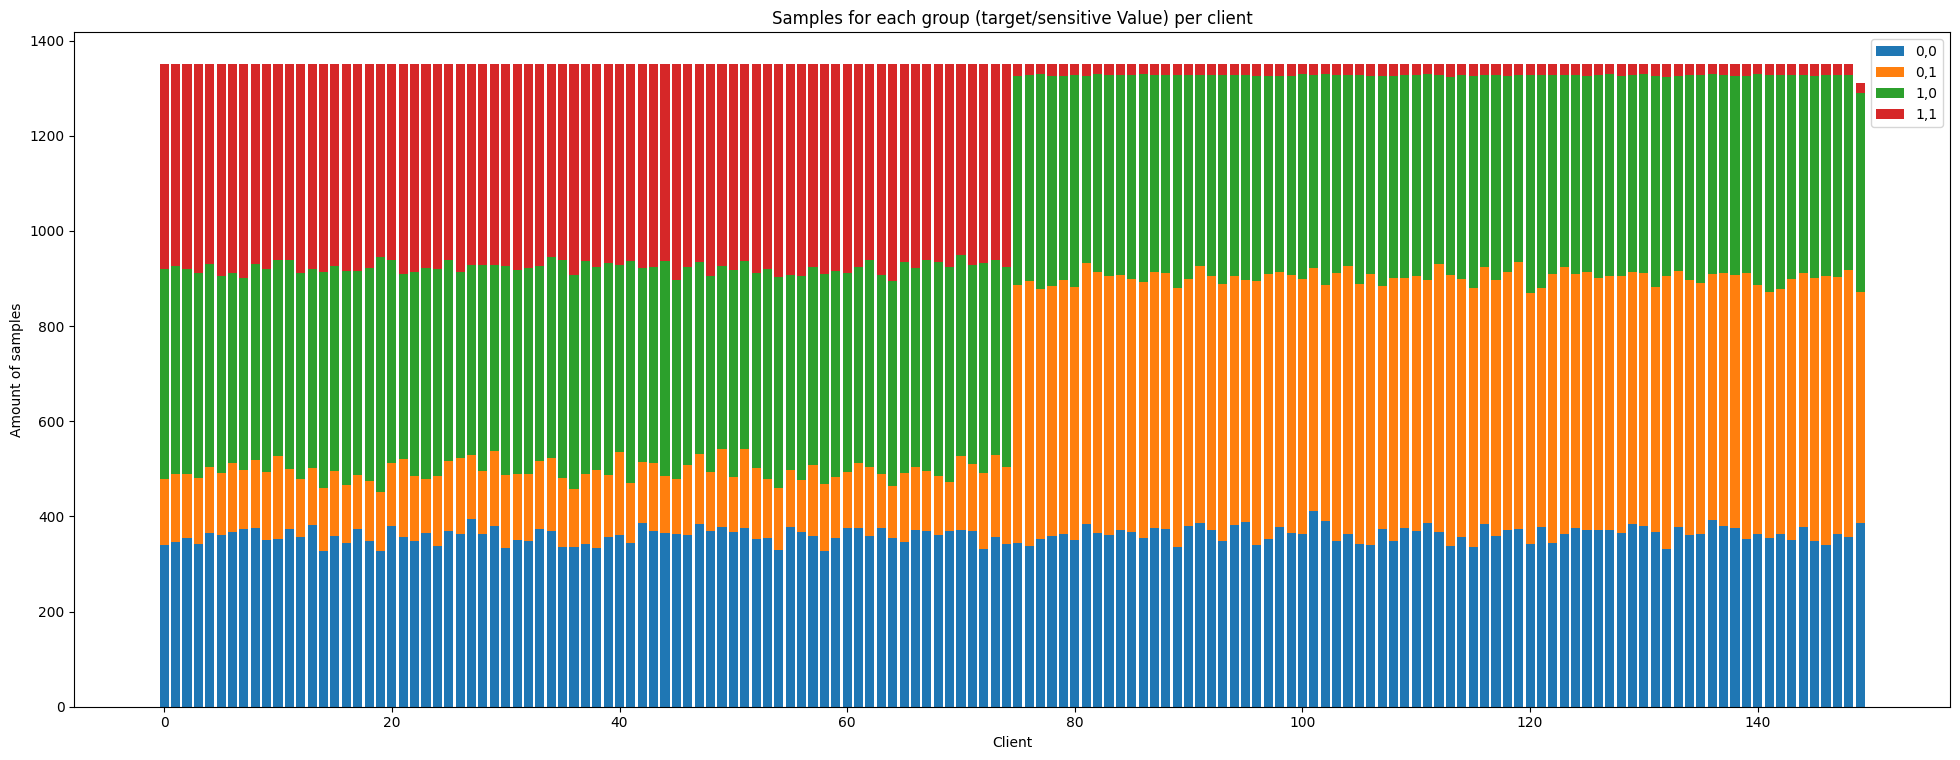

In [7]:
counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]
print(counter_groups[0])
print(counter_groups[-1])
counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

 # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
 # for each client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
plt.bar(range(len(counter_group_1_0)), counter_group_1_0, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)])
plt.bar(range(len(counter_group_1_1)), counter_group_1_1, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)])



plt.xlabel("Client")
plt.ylabel("Amount of samples")
plt.title("Samples for each group (target/sensitive Value) per client")
plt.legend(["0,0", "0,1", "1,0", "1,1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()

#group_to_reduce=(0,1), group_to_increment=(1,1),
# 0, 0 -> 1, 0

# Original

In [28]:
celeba_df = pd.read_csv("./data/celeba/original_merged.csv")
celeba_df.shape

(202599, 43)

In [29]:
labels = celeba_df["Smiling"].values
gender = celeba_df["Male"].values
combinations = [(label, gen) for label, gen in zip(labels, gender)]
combinations_with_index = [
    (label, gen, index) for index, (label, gen) in enumerate(zip(labels, gender))
]
counter_combinations = Counter(combinations)
counter_combinations

Counter({(1, -1): 63871, (-1, 1): 50636, (-1, -1): 54294, (1, 1): 33798})

In [30]:
# celeba_df.to_csv("./data/celeba/new_test_reduced.csv", index=False)

In [31]:
train_set, test_set = DatasetUtils.download_dataset(
    "celeba",
    train_csv="original_merged",
    debug=True,
    base_path="./data/celeba",
)

In [32]:
train_path = Utils.prepare_dataset_for_FL(
    dataset=train_set,
    dataset_name="celeba",
    base_path="./data",
)

Generating unified dataset
Data Correctly downloaded


In [33]:
images, sensitive_attribute, labels = torch.load(train_path)
mapping = {-1: 0, 1: 1}
sensitive_attribute = torch.tensor([mapping[item] for item in sensitive_attribute])

idx = torch.tensor(list(range(len(images))))
dataset = [idx, sensitive_attribute, labels]
pool_size = 150
group_to_reduce = (1, 1)
group_to_increment = (0, 1)

Mean of disparity 0.1402708967791209 - std 0.025072195188545508


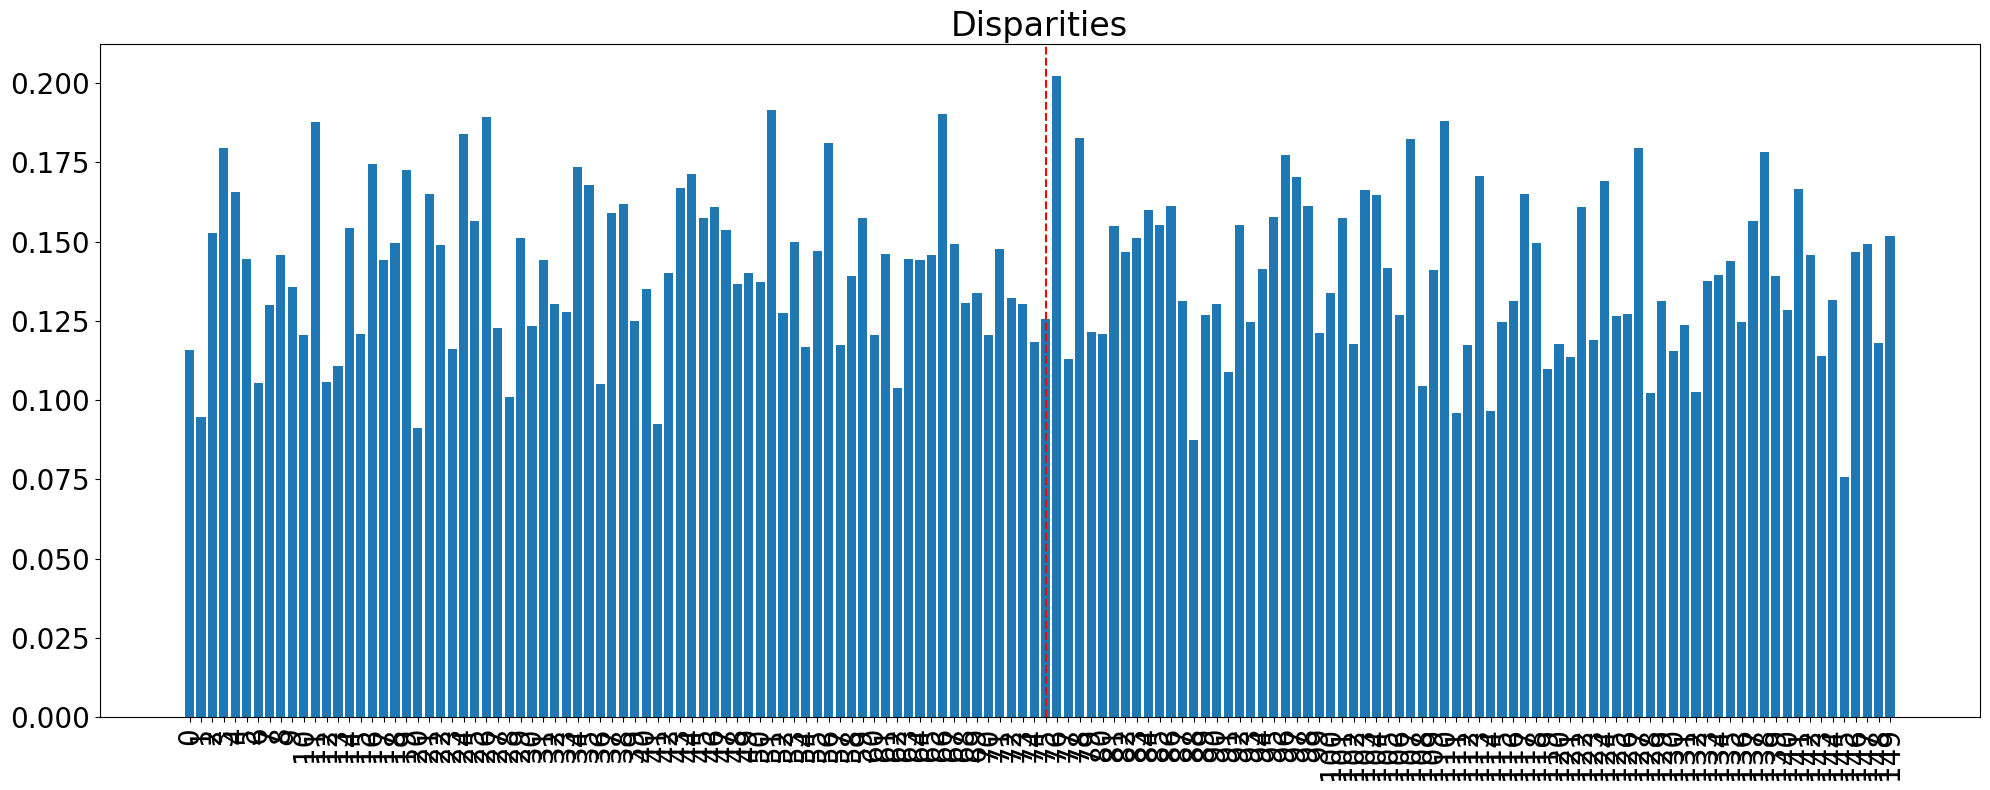

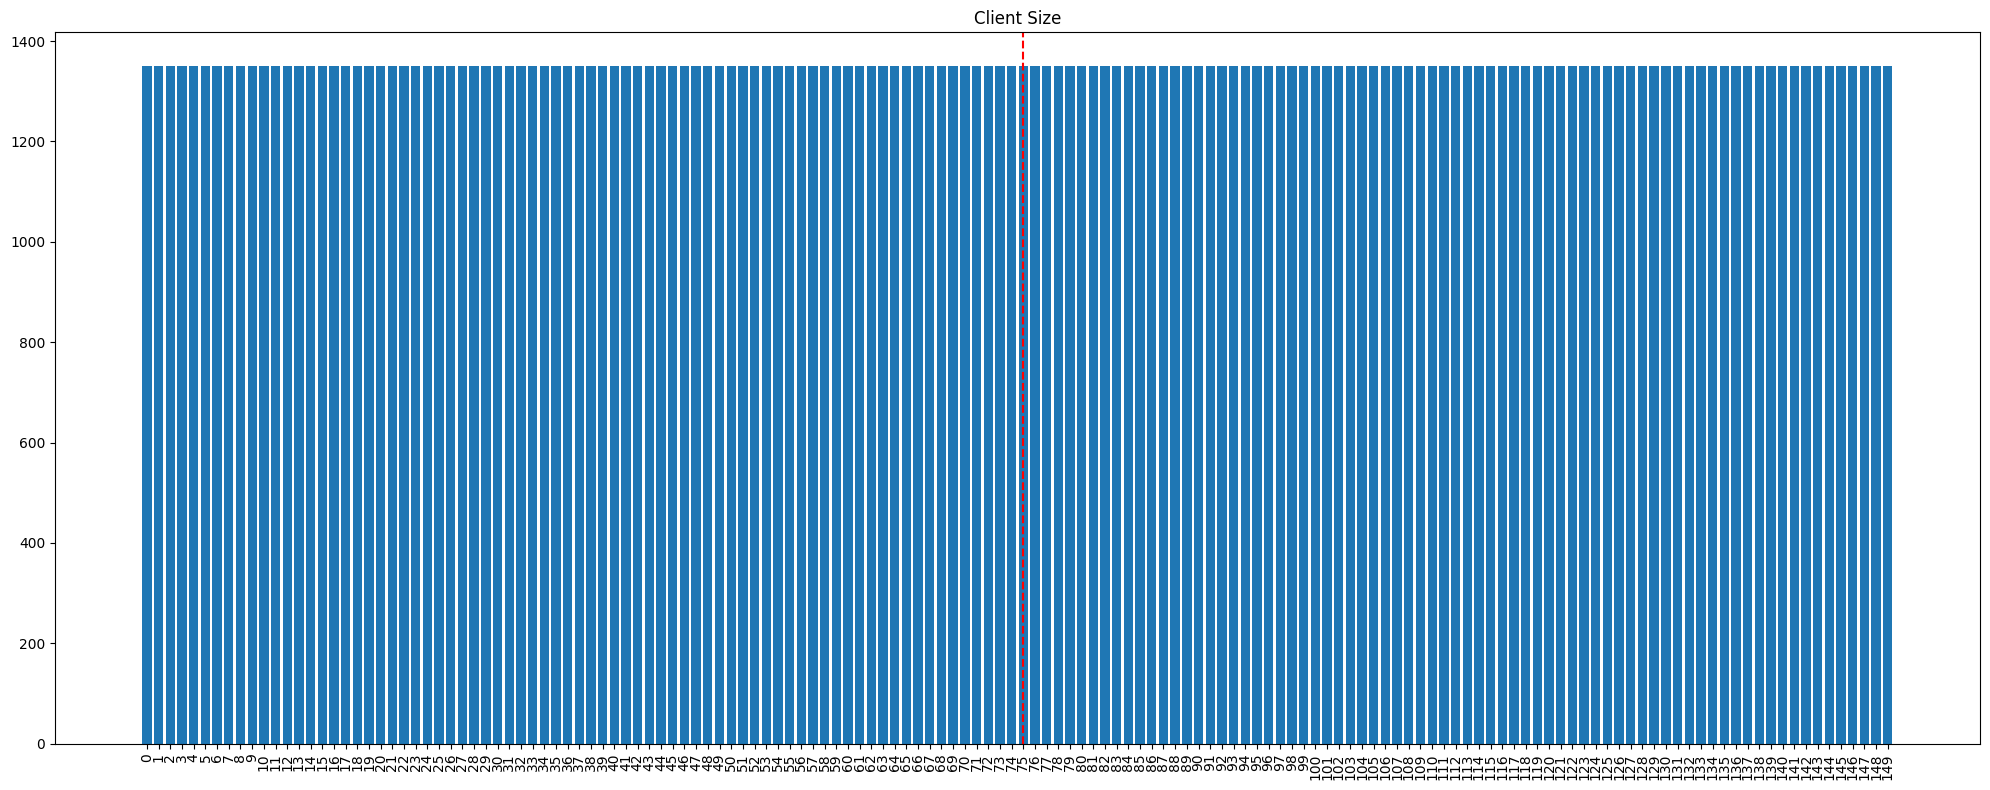

In [34]:
number_of_samples_per_node = None
ratio_unfair_nodes = 0.50
ratio_unfairness = (0, 0)
partitions_index_list, metadata = Representative.do_partitioning(
    labels=labels,
    sensitive_features=sensitive_attribute,
    num_partitions=pool_size,
    total_num_classes=2,
    group_to_reduce=group_to_reduce,
    group_to_increment=group_to_increment,
    number_of_samples_per_node=number_of_samples_per_node,
    ratio_unfair_nodes=ratio_unfair_nodes,
    ratio_unfairness=ratio_unfairness,
)
partitions = PartitionUtils.create_splitted_dataset_from_tuple(
    splitted_indexes=partitions_index_list,
    dataset=dataset,
)

In [35]:
clients_target_sensitive = []
combinations = []
for partition in partitions:
    targets = partition[2]
    sensitive = partition[1]
    clients_target_sensitive.append([(target.item(), sv.item()) for target, sv in zip(targets, sensitive)])

Counter({(1, 0): 420, (0, 0): 366, (0, 1): 328, (1, 1): 236})
Counter({(1, 0): 454, (0, 0): 357, (0, 1): 319, (1, 1): 220})


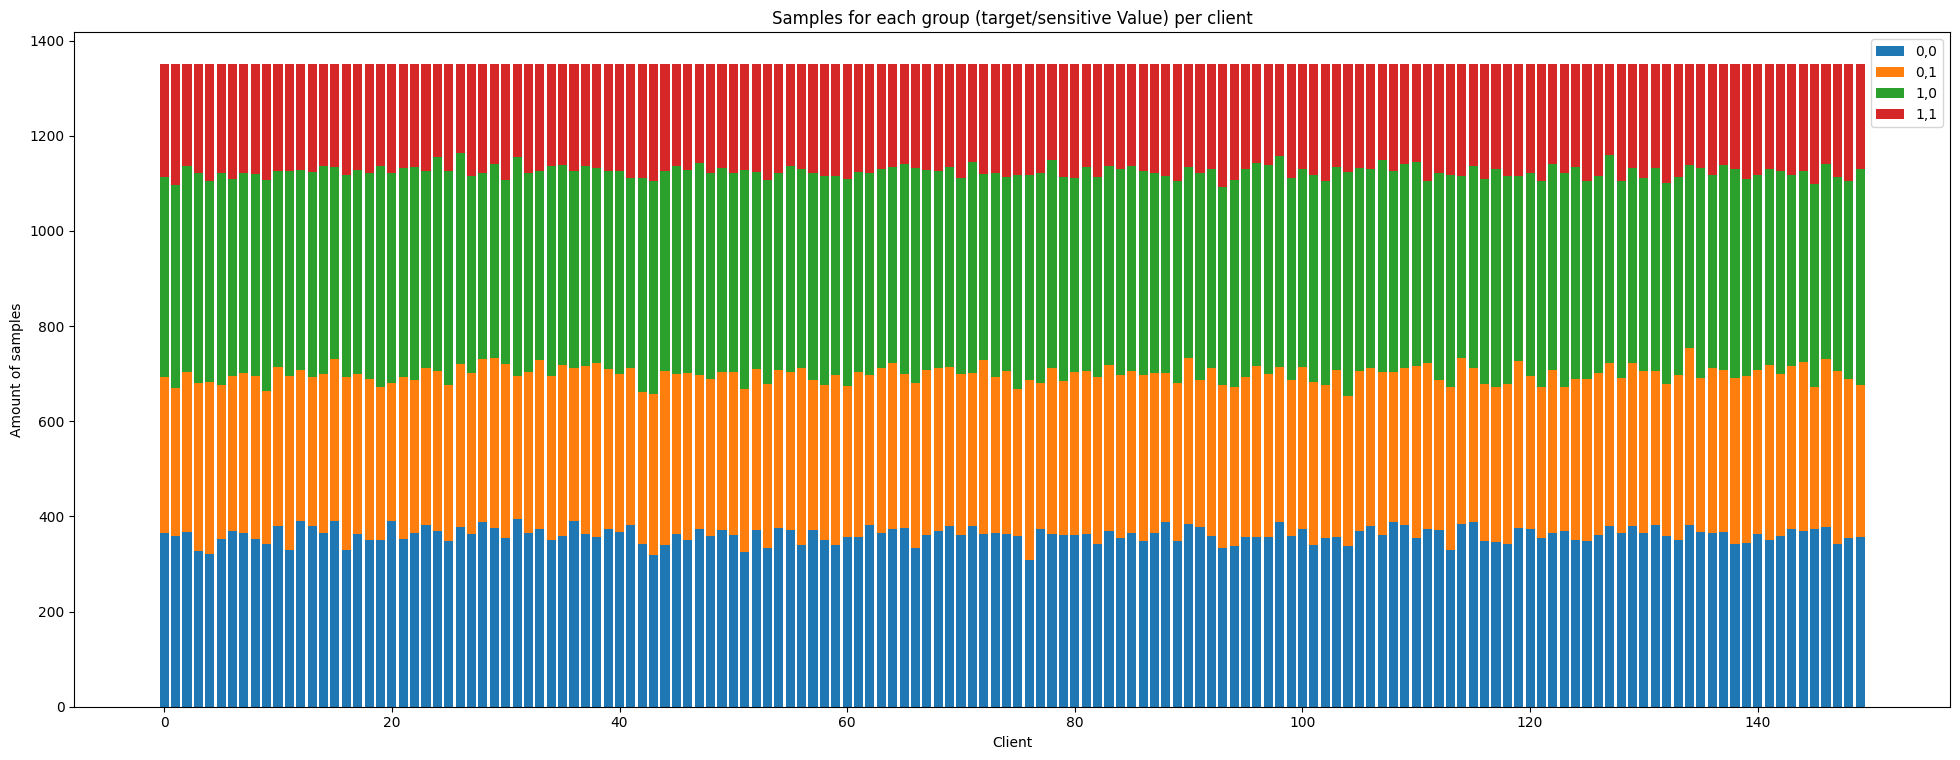

In [36]:
counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]
print(counter_groups[0])
print(counter_groups[-1])
counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

 # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
 # for each client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
plt.bar(range(len(counter_group_1_0)), counter_group_1_0, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)])
plt.bar(range(len(counter_group_1_1)), counter_group_1_1, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)])



plt.xlabel("Client")
plt.ylabel("Amount of samples")
plt.title("Samples for each group (target/sensitive Value) per client")
plt.legend(["0,0", "0,1", "1,0", "1,1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()

#group_to_reduce=(0,1), group_to_increment=(1,1),
# 0, 0 -> 1, 0

# Balanced and Unbalanced

In [37]:
images, sensitive_attribute, labels = torch.load(train_path)
mapping = {-1: 0, 1: 1}
sensitive_attribute = torch.tensor([mapping[item] for item in sensitive_attribute])

idx = torch.tensor(list(range(len(images))))
dataset = [idx, sensitive_attribute, labels]
pool_size = 150
group_to_reduce = (1, 1)
group_to_increment = (0, 1)

In [38]:
partitions_index_list, metadata = BalancedAndUnbalanced.do_partitioning(
    labels=labels,
    sensitive_features=sensitive_attribute,
    num_partitions=pool_size,
    total_num_classes=2,
    alpha=5,
    percentage_unbalanced_nodes=0.5,
    unbalanced_ratio=0.5,
)

LENGHT:  [63871, 50636, 54294, 33798]
We're using 135192 instances
Len Balanced 75 Len Unbalanced 75


In [39]:
partitions = PartitionUtils.create_splitted_dataset_from_tuple(
    splitted_indexes=partitions_index_list,
    dataset=dataset,
)

In [40]:
clients_target_sensitive = []
combinations = []
targets_nodes = []
sensitive_values_nodes = []
for partition in partitions:
    targets = partition[1]
    sensitive = partition[2]
    targets_nodes.append(targets)
    sensitive_values_nodes.append(sensitive)
    clients_target_sensitive.append([(target.item(), sv.item()) for target, sv in zip(targets, sensitive)])

In [41]:
disparities = Representative.compute_disparities_debug(predictions=targets_nodes, sensitive_features=sensitive_values_nodes)

Mean of disparity 0.14681145429869824 - std 0.1252338280362233


Counter({(0, 0): 241, (0, 1): 231, (1, 0): 219, (1, 1): 210})
Counter({(1, 0): 329, (0, 1): 251, (0, 0): 224, (1, 1): 97})


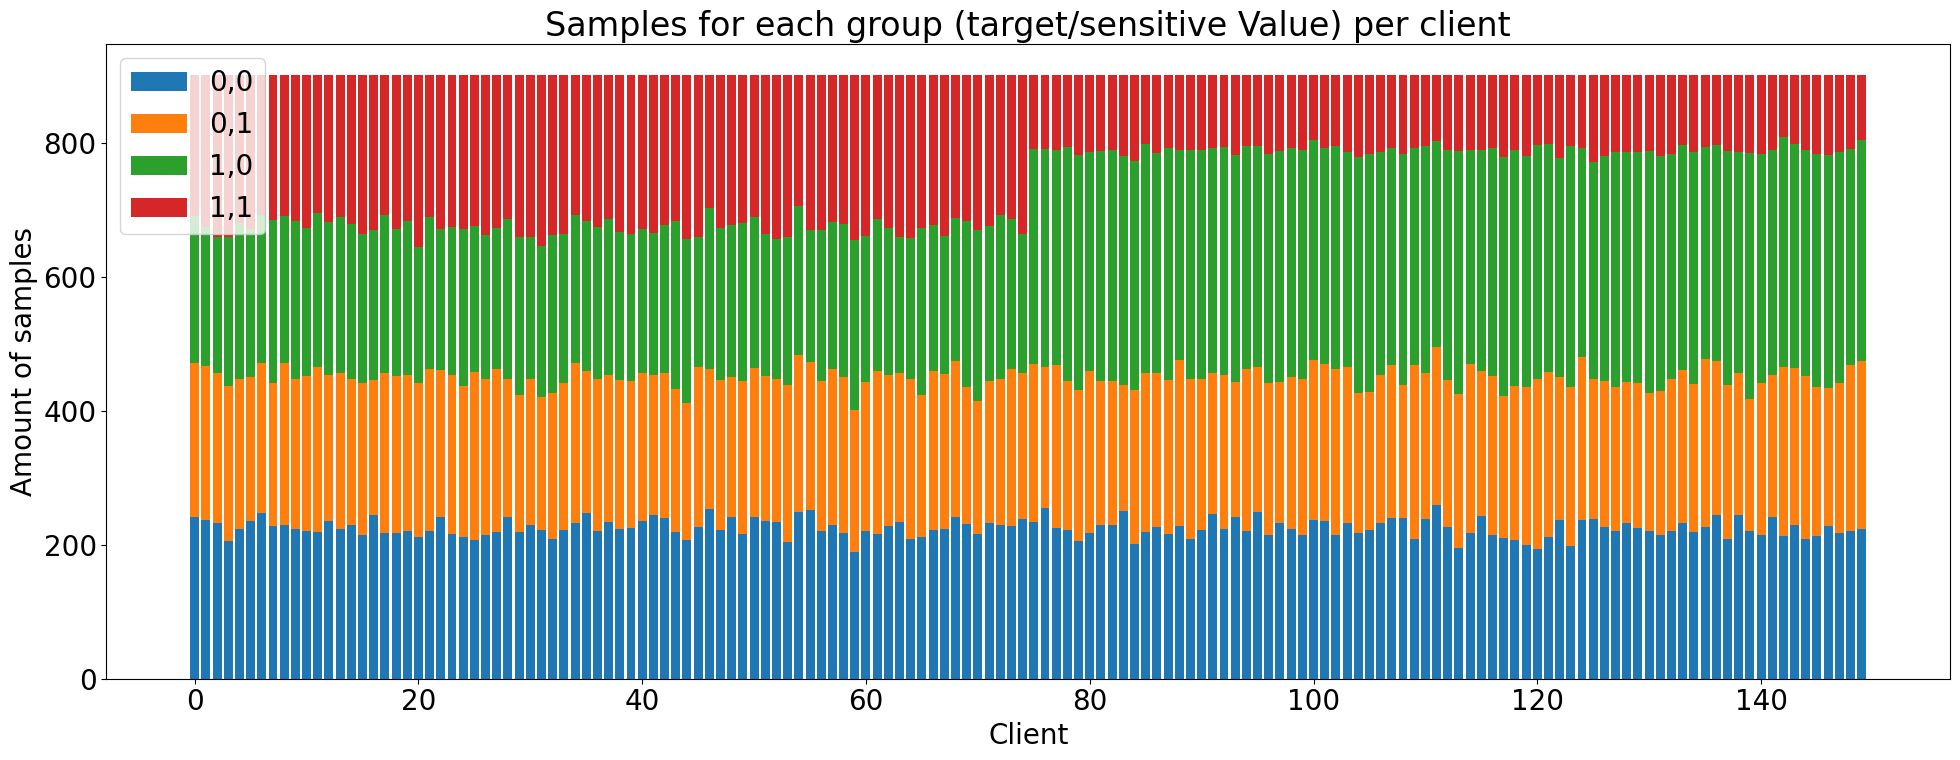

In [42]:
counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]
print(counter_groups[0])
print(counter_groups[-1])
counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

 # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
 # for each client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
plt.bar(range(len(counter_group_1_0)), counter_group_1_0, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)])
plt.bar(range(len(counter_group_1_1)), counter_group_1_1, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)])



plt.xlabel("Client")
plt.ylabel("Amount of samples")
plt.title("Samples for each group (target/sensitive Value) per client")
plt.legend(["0,0", "0,1", "1,0", "1,1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()

#group_to_reduce=(0,1), group_to_increment=(1,1),
# 0, 0 -> 1, 0